In [7]:
from mesa import Agent, Model
from mesa.space import NetworkGrid
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
import networkx as nx
import graph_init
import pandas as pd
import station as st

import network_example as ne
import numpy as np
import pathfinding as pf
import graph_functions as gf
import matplotlib.pyplot as plt
import Optimize_gradient_free as ogf
import model as m
import commuter as c
import bike_dist_hist as hist
import bike_dist_anim as anim

# Simulation
Run the simulation with this code using a basic network example graph. Use the histogram and animation functions to see the bike distribution

In [8]:
bike_distribution = {
    0:10,
    1:0,
    2:0,
    3:0
}

model = m.MyModel(100, seed=2, G=ne.basic_graph(capacity=10)[0], bike_init=bike_distribution)
for i in range(10000):
    model.step()

agent_data = model.datacollector.get_agent_vars_dataframe()
pd.reset_option('display.max_rows', None)
agent_data[['Distance_Left', "Position", 'Intermediate_Node', 'Destination', 'All Station Capacity', 'Biking', 'Park Failures']]



KeyboardInterrupt: 

In [ ]:
anim.animate(agent_data)

In [ ]:
hist.hist(agent_data)

Generate an image of the network example graph which the above simulation uses

Station 0 has 3 bikes
Station 1 has 3 bikes
Station 2 has 3 bikes
Station 3 has 3 bikes


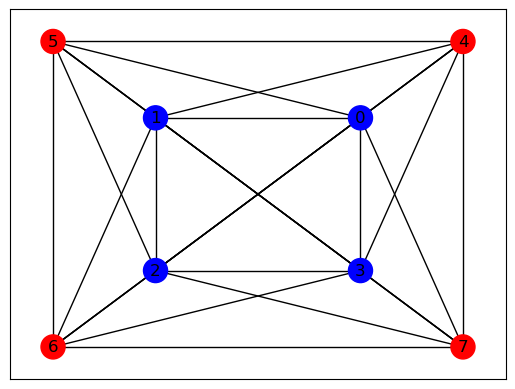

In [9]:
n_stations = 4
G, total_nodes = ne.basic_graph()
pos = {i: total_nodes[i] for i in range(total_nodes.shape[0])}
colors = ['r' if G.nodes[i]['type'] == 'destination' else 'b' for i in G.nodes]
nx.draw_networkx(G, pos, node_color=colors, with_labels=True)
# print the number of bikes at each station
for i in range(n_stations):
    print('Station', i, 'has', G.nodes[i]['data'].available_bikes, 'bikes')

### Optimizer
Use the bottom cell to input some of the parameters such as the destination coordinates and the probability distribution for each destinations (weights)
- First let's start with a simple, 2 destination and 2 station graph

In [10]:
### parameters
destinations_coords = [
    (0, -4.5), 
    (0, 4.5), 
]

# weights for each destination (add up to 1)
w = [0.75, 0.25]

In [11]:
G,s,d = gf.create_graph_from_coordinates([], destinations_coords)

Visualize the initial destination graph, see which stations are which (adjust the draw network function to fit the destination coordinates)

{0: {'pos': (-4.5, 0), 'type': 'destination', 'data': None}, 1: {'pos': (4.5, 0), 'type': 'destination', 'data': None}}


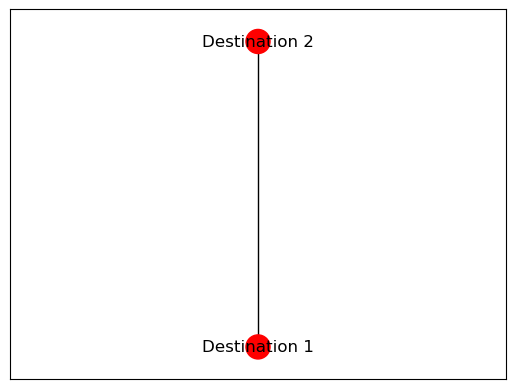

In [12]:
pos = {i: d["Destination " + str(i+1)] for i in range(len(d))}
print(pos)
colors = ['r' if G.nodes[i]['type'] == 'destination' else 'b' for i in G.nodes]
nx.draw_networkx(G, {"Destination 1": [0, -4.5], "Destination 2": [0, 4.5]}, node_color = colors, with_labels=True)

Optimizer: 
- can use either genetic or PSO optimizer, just switch the optimizer
- also need to input destination coordinates here again
- adjust city map to fit the destination coords inside of it
- plots the loss curve
- second cell plots the optimized stations in the destination map

-4.5


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0: Best fitness: -3.0
Iteration 10: Best fitness: -3.6
Iteration 20: Best fitness: -3.75
Iteration 30: Best fitness: -3.9
Iteration 40: Best fitness: -3.9


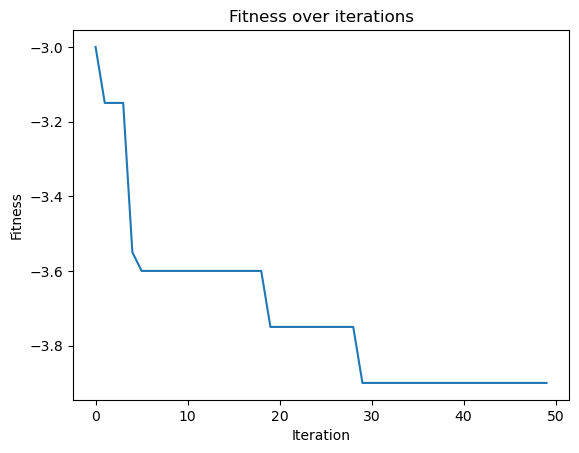

-3.9
[(-0.2557868985832984, 3.920611358793456), (-0.28140135167527575, -3.482077596315356)]


In [15]:
destinations = [i for i in G.nodes if G.nodes[i]['type'] == 'destination']

destinationcoords = [
    (0, -4.5), 
    (0, 4.5), 
]

G,s,d = gf.create_graph_from_coordinates([], destinationcoords)
citymap = [(-6,-6), (6,6)] + destinationcoords
def fitness(coordinatelist):
    destinations = coordinatelist["destination"]
    stations = coordinatelist["station"]
    G, s, d, = gf.create_graph_from_coordinates(stations, destinations)
    model = m.MyModel(20, seed=1, G=G, weights = w)
    for i in range(100):
        model.step()
    return model.walking_average()

print(fitness({"destination": destinationcoords, "station": destinationcoords}))

optimizer = ogf.Optimize(citymap, fitness, 0.7,1.4,1.4)
bestpos, bestfit = optimizer.optimize_PSO(20, 2, 50)

## uncomment for genetic algorithm
# bestpos, bestfit = optimizer.optimize_PSO(20, 2, 50, mutation_rate = 0.7, alpha = 0.3) 

optimizer.plot_losses()
print(bestfit)
stations = [(bestpos[i], bestpos[i+1]) for i in range(0, len(bestpos), 2)]
print(stations)
G, s, d, = gf.create_graph_from_coordinates(stations, destinationcoords)

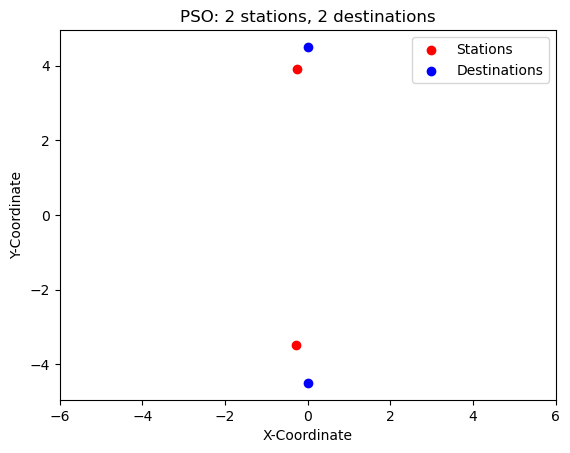

In [16]:
plt.scatter([station[0] for station in stations], [station[1] for station in stations], c='red', label='Stations')
plt.scatter([destination[0] for destination in destinationcoords], [destination[1] for destination in destinationcoords], c='blue', label='Destinations')
plt.xlabel('X-Coordinate')
plt.ylabel('Y-Coordinate')
plt.xlim(-6, 6)

plt.title('PSO: 2 stations, 2 destinations')
plt.legend()
# plt.savefig('PSO_2_2_2weight.png')
plt.show()

# Optimizer with 4 destinations, 2 stations
follows the same logic as before, but will change some parameters for additinal destinations

In [17]:
### parameters
destinations_coords = [
    (0, -4.5), 
    (0, 4.5), 
    (4.5,0),
    (-4.5,0)
]

# weights for each destination (add up to 1)
w = [0.7, 0.1, 0.1, 0.1]

In [18]:
G,s,d = gf.create_graph_from_coordinates([], destinations_coords)

{0: {'pos': (-4.5, 0), 'type': 'destination', 'data': None}, 1: {'pos': (4.5, 0), 'type': 'destination', 'data': None}, 2: {'pos': (0, 4.5), 'type': 'destination', 'data': None}, 3: {'pos': (0, -4.5), 'type': 'destination', 'data': None}}


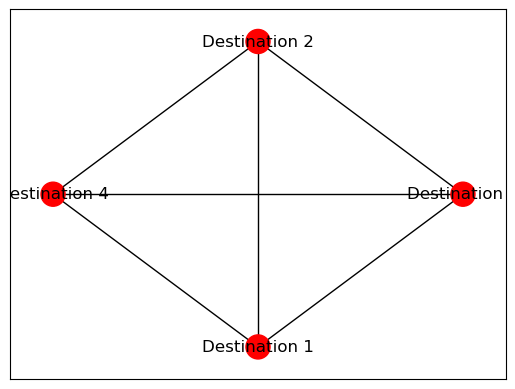

In [20]:
pos = {i: d["Destination " + str(i+1)] for i in range(len(d))}
print(pos)
colors = ['r' if G.nodes[i]['type'] == 'destination' else 'b' for i in G.nodes]
nx.draw_networkx(G, {"Destination 1": [0, -4.5], "Destination 2": [0, 4.5], "Destination 3": [4.5, 0], "Destination 4": [-4.5,0]}, node_color = colors, with_labels=True)

-6.35


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0: Best fitness: -4.0
Iteration 10: Best fitness: -4.15
Iteration 20: Best fitness: -4.3
Iteration 30: Best fitness: -4.3
Iteration 40: Best fitness: -4.35


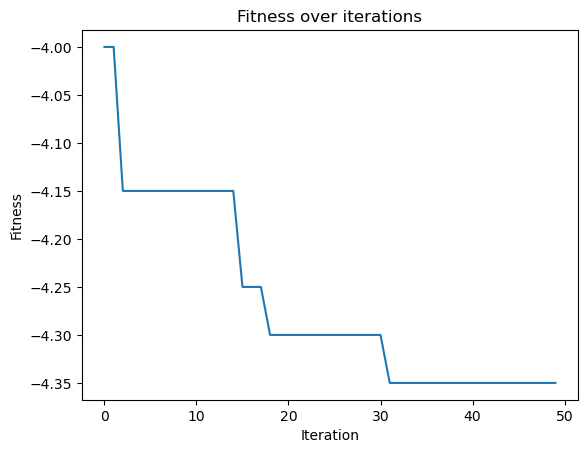

-4.35
[(4.5869619752587365, -0.3696042212240764), (0.227415370875743, -3.609740925010277)]


In [21]:
destinations = [i for i in G.nodes if G.nodes[i]['type'] == 'destination']

destinationcoords = [
    (0, -4.5), 
    (0, 4.5), 
    (4.5,0),
    (-4.5,0)
]

G,s,d = gf.create_graph_from_coordinates([], destinationcoords)
citymap = [(-6,-6), (6,6)] + destinationcoords
def fitness(coordinatelist):
    destinations = coordinatelist["destination"]
    stations = coordinatelist["station"]
    G, s, d, = gf.create_graph_from_coordinates(stations, destinations)
    model = m.MyModel(20, seed=1, G=G, weights = w)
    for i in range(100):
        model.step()
    return model.walking_average()

print(fitness({"destination": destinationcoords, "station": destinationcoords}))

optimizer = ogf.Optimize(citymap, fitness, 0.7,1.4,1.4)
bestpos, bestfit = optimizer.optimize_PSO(20, 2, 50)

## uncomment for genetic algorithm
# bestpos, bestfit = optimizer.optimize_PSO(20, 2, 50, mutation_rate = 0.7, alpha = 0.3) 

optimizer.plot_losses()
print(bestfit)
stations = [(bestpos[i], bestpos[i+1]) for i in range(0, len(bestpos), 2)]
print(stations)
G, s, d, = gf.create_graph_from_coordinates(stations, destinationcoords)

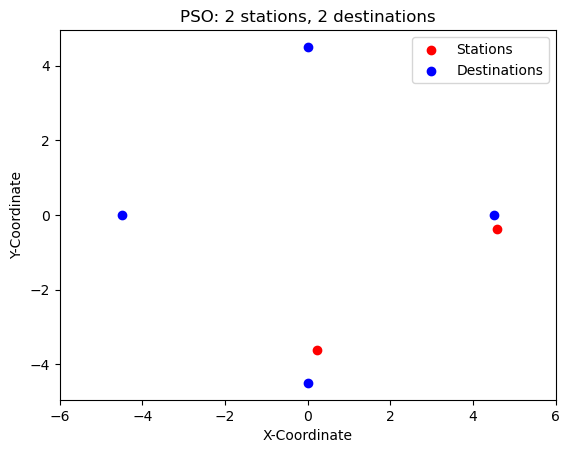

In [22]:
plt.scatter([station[0] for station in stations], [station[1] for station in stations], c='red', label='Stations')
plt.scatter([destination[0] for destination in destinationcoords], [destination[1] for destination in destinationcoords], c='blue', label='Destinations')
plt.xlabel('X-Coordinate')
plt.ylabel('Y-Coordinate')
plt.xlim(-6, 6)

plt.title('PSO: 2 stations, 2 destinations')
plt.legend()
# plt.savefig('PSO_2_2_2weight.png')
plt.show()

Using this implementation, run with different number of destinations and stations. Next, let's optimize UT's map
### UT map optimization

In [ ]:
### VIREN ADD IN CODE HERE